In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import scipy.linalg as LIN
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.weight'] = 'medium'

%matplotlib inline

In [2]:
np.random.seed(199)

In [3]:
# get left and right eigenvectors associated with the 
# largest eigenvalue. For a symmetric matrix, its left
# and right eigenvectors are the same. 
def getLREigVec(mat):
    eigVals_, eigL_, eigR_ = LIN.eig(mat, left=True)
    idx_max = np.argmax(eigVals_)
    t = eigL_[:, idx_max]
    h = eigR_[:, idx_max]
    return t, h

# compute gradient (Eq.(12) in the write-up)
def gradient(adjMat, S, Alpha, adjMatMask):
    n = adjMat.shape[0]
    alpha1, alpha2, alpha3 = Alpha
    
    ## for 1st term, to increase the largest eigenvalue
    ## of the subgraph
    S_adjMat = adjMat[np.ix_(S, S)]
    # t_S, h_S: left, right eigenvectors of the subgraph, respectively
    t_S, h_S = getLREigVec(S_adjMat)
    g_1 = np.zeros(adjMat.shape)
    g_1[np.ix_(S, S)] = np.outer(t_S, h_S)
    g_1 = np.multiply(g_1, adjMatMask)

    ## for 2nd term, to not increase the largest eigenvalue
    ## too much
    t, h = getLREigVec(adjMat)
    g_2 = np.outer(t, h)
    g_2 = np.multiply(g_2, adjMatMask)

    ## for 3rd term, to increase the centrality of the subgraph
    x_S = np.zeros(len(G.nodes))
    x_S[S] = 1
    X_S = np.outer(x_S, x_S)
    P = np.transpose( 2 * X_S - (np.multiply(X_S, np.identity(n))) )
    g_3 = np.dot(np.multiply(P, np.identity(n)), np.ones((n, n))) - P
    g_3 = np.multiply(g_3, adjMatMask)
    # no need to change the edges' weights within the subgraph
    g_3[np.ix_(S, S)] = 0
    
    return np.real( alpha1 * g_1 - alpha2 * g_2 + alpha3 / len(S) * g_3 )

# get the largest eigenvalue
def maxEig(mat):
    eigVals = LIN.eigvals(mat)
    return np.max(eigVals)

# get a submatrix of mat indexed by S
def getSubmat(mat, S):
    return mat[np.ix_(S, S)]

# get the Laplacian matrix corresponding to mat
def getL(mat):
    degs = np.dot(mat, np.ones(mat.shape[1]))
    return np.diag(degs) - mat

In [5]:
n = 20
G = nx.barabasi_albert_graph(n, 2)

In [6]:
adjMat = np.asarray(nx.adjacency_matrix(G).todense())
adjMatMask = np.copy(adjMat)

In [7]:
# trade-off parameters
alpha1, alpha2, alpha3 = 0.5, 0.3, 0.2
ret = {'Lambda': [], 'Lambda_S': [], 'Centrality': [], 'Utility': []}
Gradient = []

# subgraph is the induced subgraph of S
S = [1, 2, 3]
x_S = np.zeros(len(G.nodes))
x_S[S] = 1

Iter = 100
lr = 0.1
adjMat_0 = np.copy(adjMat)

# gradient ascent 
for ii in range(Iter):
    # compute eigenvalues
    lambda_1 = np.real(maxEig(adjMat))
    lambda_1_S = np.real(maxEig(getSubmat(adjMat, S)))
    
    # compute centrality
    L = getL(adjMat)
    Cent = np.real( np.dot(x_S, np.dot(L, x_S)) / len(S) )
    
    # compute utility
    utility = np.real( alpha1 * lambda_1_S - alpha2 * lambda_1 + alpha3 * Cent )
    
    # printing and recording intermediate results
    if ii % 10 == 0:
        print("Lambda_S: %.4f      Lambda: %.4f      Centrality: %i      Utility: %.4f" % (lambda_1_S, lambda_1, Cent, utility))
    ret['Lambda'].append(lambda_1)
    ret['Lambda_S'].append(lambda_1_S)
    ret['Centrality'].append(Cent)
    ret['Utility'].append(utility)
    
    # update gradient
    g = gradient(adjMat, S, [alpha1, alpha2, alpha3], adjMatMask)
    Gradient.append(np.copy(g))
    adjMat = adjMat + lr * g

# convert results into DataFrame
ret = pd.DataFrame(ret)

Lambda_S: 1.4142      Lambda: 4.5669      Centrality: 5      Utility: 0.4704
Lambda_S: 1.6056      Lambda: 4.6305      Centrality: 5      Utility: 0.5957
Lambda_S: 1.7932      Lambda: 4.6977      Centrality: 6      Utility: 0.7189
Lambda_S: 1.9772      Lambda: 4.7675      Centrality: 6      Utility: 0.8403
Lambda_S: 2.1579      Lambda: 4.8393      Centrality: 6      Utility: 0.9604
Lambda_S: 2.3355      Lambda: 4.9123      Centrality: 6      Utility: 1.0795
Lambda_S: 2.5103      Lambda: 4.9860      Centrality: 7      Utility: 1.1980
Lambda_S: 2.6824      Lambda: 5.0597      Centrality: 7      Utility: 1.3163
Lambda_S: 2.8523      Lambda: 5.1330      Centrality: 7      Utility: 1.4347
Lambda_S: 3.0201      Lambda: 5.2054      Centrality: 8      Utility: 1.5535


Text(0.5, 0, 'iterations')

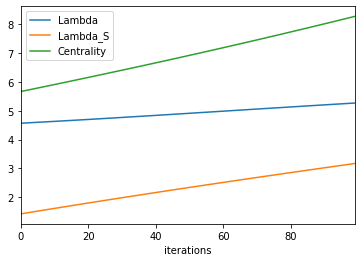

In [8]:
# plot results
ret[['Lambda', 'Lambda_S', 'Centrality']].plot(kind='line')
plt.xlabel('iterations')